# Predicting Water Pump Functionality in Tanzania (HydroLogic Project)
Authored by Farzaneh Gerami, Subaye Opoku-Acquah & Mariam Farda | 
March – June 2025

# Imports

In [38]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import f_oneway

import math

import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import joblib

import geopandas as gpd
from shapely.geometry import Point
import folium

In [39]:
df_cleaned = pd.read_csv("../data/processed/cleaned_merged_data.csv")

In [40]:
df_cleaned.head()

amount_tsh date_recorded        funder  gps_height     installer  \
0    1.739787    2011-03-14         Roman    1.010140         Roman   
1   -0.620930    2013-03-06       Grumeti    1.023116       GRUMETI   
2    0.559429    2013-02-25  Lottery Club   -0.004915  World vision   
3   -0.620930    2013-01-28        Unicef   -0.614813        UNICEF   
4   -0.620930    2011-07-13   Action In A   -0.994017       Artisan   

   longitude   latitude              wpt_name                    basin  \
0  34.938093  -9.856322                  none               lake nyasa   
1  34.698766  -2.147466              Zahanati            lake victoria   
2  37.460664  -3.821329           Kwa Mahundi                  pangani   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu  ruvuma / southern coast   
4  31.130847  -1.825359               Shuleni            lake victoria   

   subvillage  ... amount_tsh_before_clip  amount_tsh_was_outlier  \
0    Mnyusi B  ...                 6000.0                    True   
1     Nyamara  ...                    0.0                   False   
2     Majengo  ...                   25.0                   False   
3  Mahakamani  ...                    0.0                   False   
4  Kyanyamisa  ...                    0.0                   False   

   population_before_clip population_was_outlier gps_height_before_clip  \
0                     109                  False                   1390   
1                     280                  False                   1399   
2                     250                  False                    686   
3                      58                  False                    263   
4                       0                  False                      0   

   gps_height_was_outlier longitude_before_clip longitude_was_outlier  \
0                   False             34.938093                 False   
1                   False             34.698766                 False   
2                   False             37.460664                 False   
3                   False             38.486161                 False   
4                   False             31.130847                 False   

  latitude_before_clip latitude_was_outlier  
0            -9.856322                False  
1            -2.147466                False  
2            -3.821329                False  
3           -11.155298                False  
4            -1.825359                False  

[5 rows x 53 columns]

In [41]:
df_cleaned['region'].unique()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

In [42]:
df_cleaned['region_clean'] = df_cleaned['region'].str.strip().str.lower()

In [43]:
# Load Tanzania ADM1 shapefile
shapefile_path = "../data/raw/geoBoundaries-TZA-ADM1-all/geoBoundaries-TZA-ADM1_simplified.shp"
geo_data = gpd.read_file(shapefile_path)


In [44]:
geo_data.head()

shapeName shapeISO                  shapeID shapeGroup shapeType  \
0  Kilimanjaro    TZ-09  36957248B55328686942733        TZA      ADM1   
1         Mara    TZ-13  36957248B94562559517692        TZA      ADM1   
2      Manyara    TZ-26  36957248B99133684808243        TZA      ADM1   
3       Arusha    TZ-01  36957248B12876867554617        TZA      ADM1   
4       Kagera    TZ-05  36957248B48065738140082        TZA      ADM1   

                                            geometry  
0  POLYGON ((37.97322 -4.58595, 37.95057 -4.56180...  
1  POLYGON ((35.22448 -2.49750, 34.60269 -2.52488...  
2  POLYGON ((37.10873 -3.47107, 37.13184 -3.46494...  
3  POLYGON ((37.40454 -2.89704, 37.38876 -2.91099...  
4  POLYGON ((32.75025 -1.00000, 32.74476 -1.46219...

In [45]:
type(geo_data)

geopandas.geodataframe.GeoDataFrame

In [46]:
print(geo_data.columns)

Index(['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType',
       'geometry'],
      dtype='object')


In [47]:
print(geo_data[['shapeName']].drop_duplicates()) 

                   shapeName
0                Kilimanjaro
1                       Mara
2                    Manyara
3                     Arusha
4                     Kagera
5                      Mbeya
6                    Singida
7                     Mtwara
8                     Iringa
9              Dar es Salaam
10                     Lindi
11                    Tabora
12                     Pwani
13                    Ruvuma
14                  Morogoro
15                     Rukwa
16                    Kigoma
17                     Tanga
18                    Dodoma
19  Zanzibar South & Central
20               North Pemba
21            Zanzibar North
22       Zanzibar Urban/West
23               South Pemba
24                    Katavi
25                    Njombe
26                     Geita
27                    Simiyu
28                    Mwanza
29                 Shinyanga


In [48]:
geo_data['region_clean'] = geo_data['shapeName'].str.strip().str.lower()

In [49]:
# Create geometry from lat/lon
geometry = [Point(xy) for xy in zip(df_cleaned["longitude"], df_cleaned["latitude"])]

In [50]:
# Convert to GeoDataFrame with WGS84 (EPSG:4326)
gdf_points = gpd.GeoDataFrame(df_cleaned, geometry=geometry, crs="EPSG:4326")

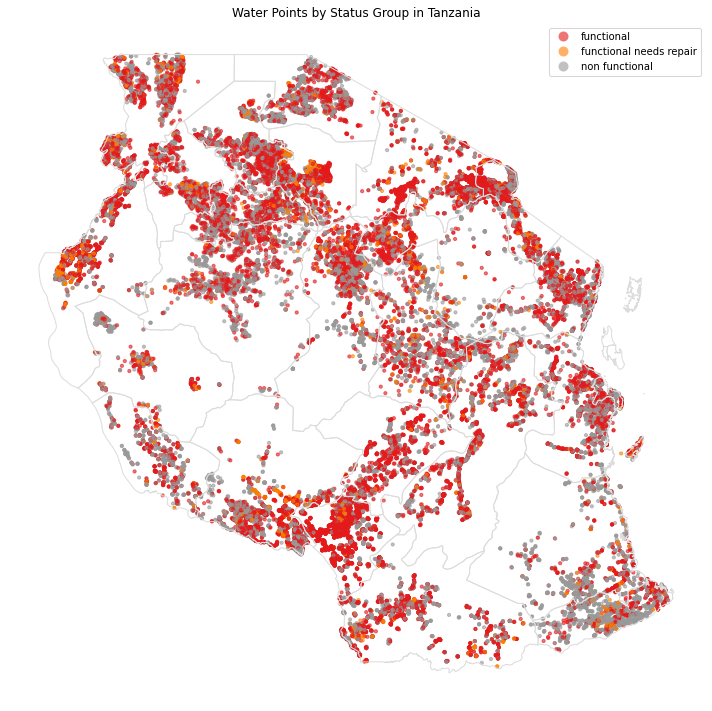

In [51]:
ax = geo_data.plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)

gdf_points.plot(
    ax=ax,
    column="status_group",
    cmap="Set1",
    markersize=10,
    legend=True,
    alpha=0.6
)
plt.title("Water Points by Status Group in Tanzania")
plt.axis("off")
plt.tight_layout()
plt.show()

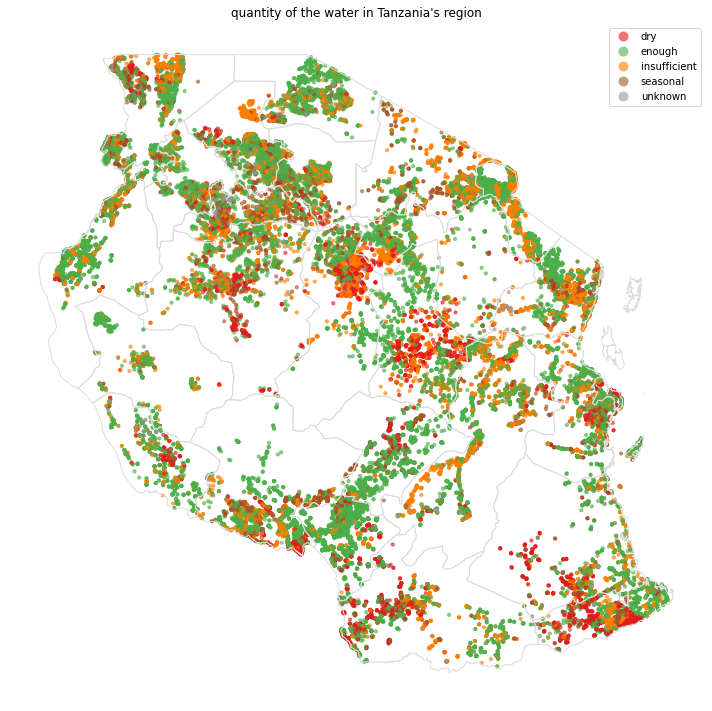

In [52]:
ax = geo_data.plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)
gdf_points.plot(
    ax=ax,
    column="quantity",
    cmap="Set1",
    markersize=10,
    legend=True,
    alpha=0.6
)
plt.title("quantity of the water in Tanzania's region")
plt.axis("off")
plt.tight_layout()
plt.show()

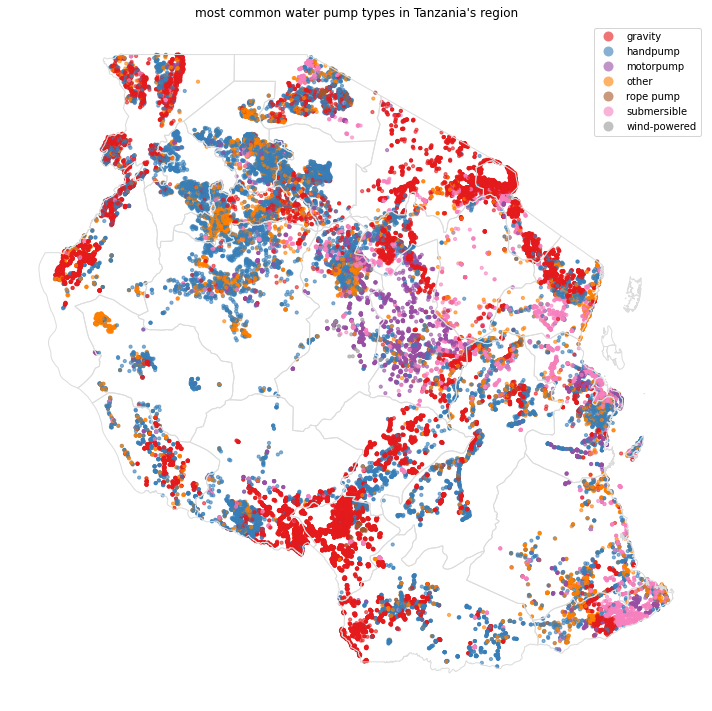

In [53]:
ax = geo_data.plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)
gdf_points.plot(
    ax=ax,
    column="extraction_type_class",
    cmap="Set1",
    markersize=10,
    legend=True,
    alpha=0.6
)
plt.title("most common water pump types in Tanzania's region")
plt.axis("off")
plt.tight_layout()
plt.show()

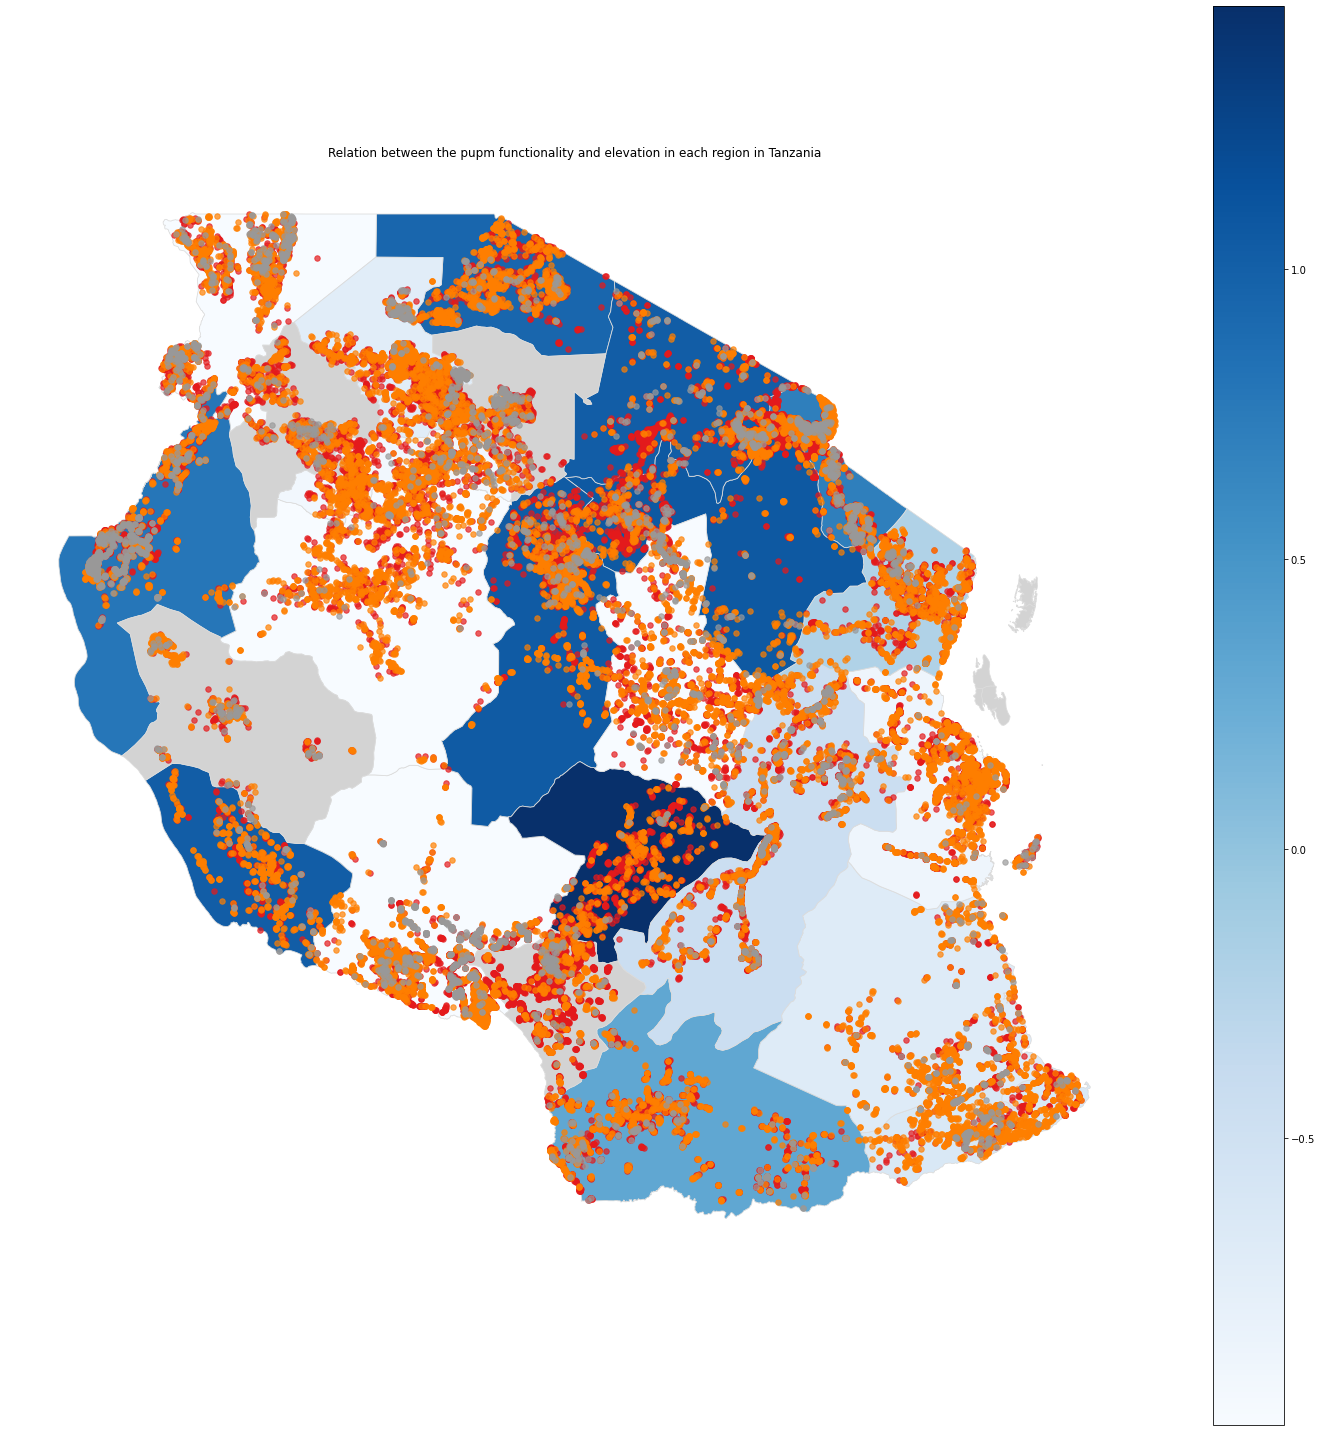

In [54]:
# Step 1: Clean and aggregate quantity by region
df_cleaned['region_clean'] = df_cleaned['region'].str.strip().str.lower()
region_quantity = df_cleaned.groupby('region_clean')['gps_height'].mean().reset_index()
region_quantity.rename(columns={'gps_height': 'avg_height'}, inplace=True)

# Step 2: Clean region names in geo_data and merge with quantity
geo_data['region_clean'] = geo_data['shapeName'].str.strip().str.lower()
geo_data = geo_data.merge(region_quantity, on='region_clean', how='left')

# Step 3: Plot Tanzania map colored by avg_quantity
ax = geo_data.plot(
    figsize=(20, 20),
    column='avg_height',
    cmap='Blues',
    edgecolor='gainsboro',
    linewidth=0.8,
    legend=True,
    zorder=3,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
unique_status = gdf_points['status_group'].dropna().unique()
cmap = plt.cm.get_cmap('Set1', len(unique_status))

for i, status in enumerate(unique_status):
    subset = gdf_points[gdf_points['status_group'] == status]
    subset.plot(
        ax=ax,
        marker='o',
        color=cmap(i),
        markersize=30,
        label=status,
        alpha=0.7,
        zorder=4
    )

plt.title("Relation between the pupm functionality and elevation in each region in Tanzania")
plt.axis("off")
plt.tight_layout()
plt.show()


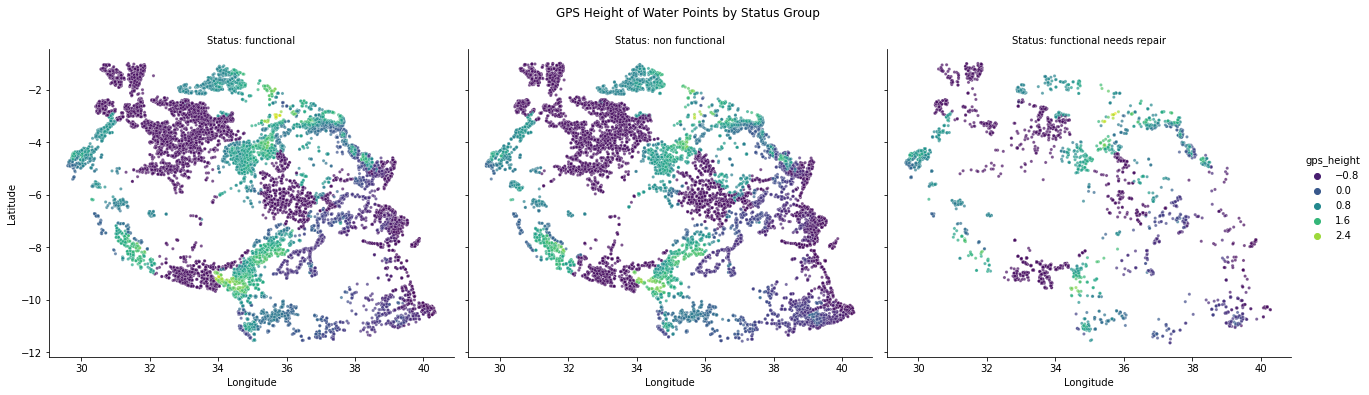

In [55]:
# Ensure we're plotting from a GeoDataFrame
gdf_points = gdf_points.dropna(subset=['gps_height'])

# Plot using seaborn and matplotlib
g = sns.relplot(
    data=gdf_points,
    x='longitude', y='latitude',
    hue='gps_height',
    palette='viridis',
    kind='scatter',
    col='status_group',  # facet by status group
    height=5, aspect=1.2,
    alpha=0.7,
    s=10
)
g.set_titles("Status: {col_name}")
g.set_axis_labels("Longitude", "Latitude")
plt.suptitle("GPS Height of Water Points by Status Group", y=1.05)
plt.show()

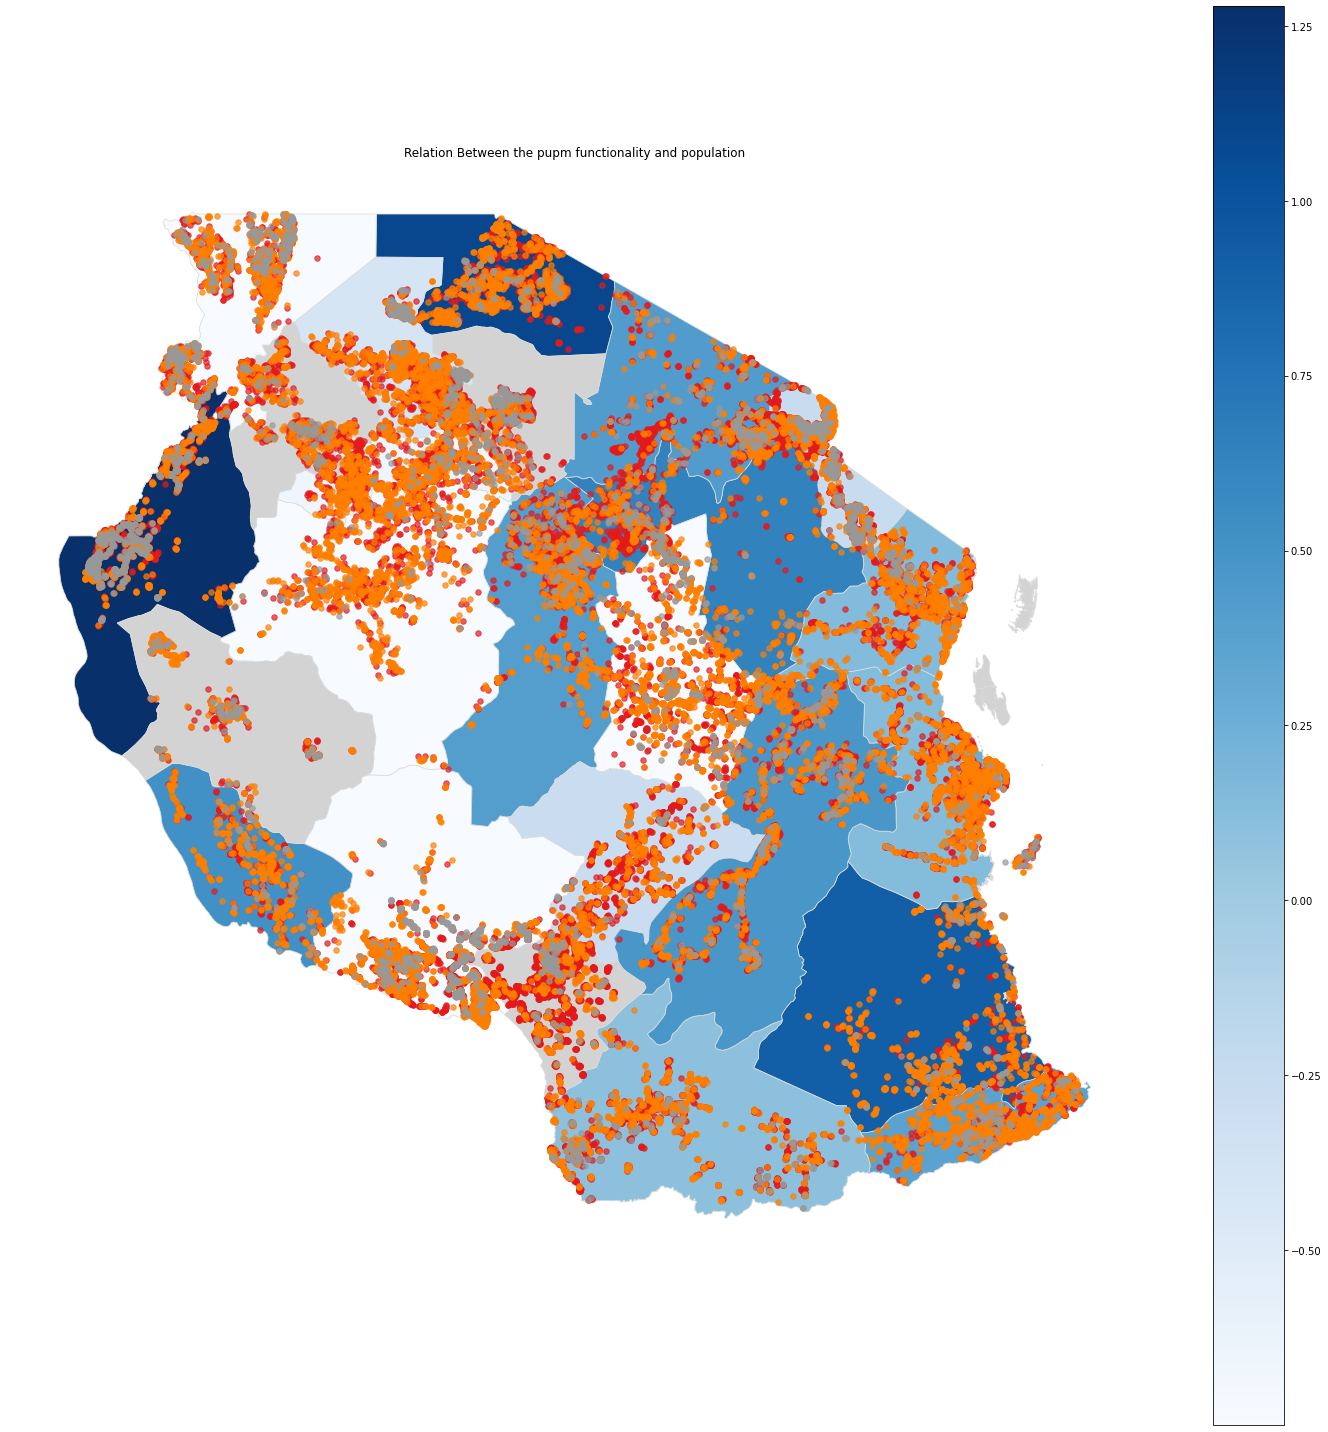

In [56]:
# Step 1: Clean and aggregate quantity by region
df_cleaned['region_clean'] = df_cleaned['region'].str.strip().str.lower()
region_quantity = df_cleaned.groupby('region_clean')['population'].mean().reset_index()
region_quantity.rename(columns={'population': 'avg_pop'}, inplace=True)

# Step 2: Clean region names in geo_data and merge with quantity
geo_data['region_clean'] = geo_data['shapeName'].str.strip().str.lower()
geo_data = geo_data.merge(region_quantity, on='region_clean', how='left')

# Step 3: Plot Tanzania map colored by avg_quantity
ax = geo_data.plot(
    figsize=(20, 20),
    column='avg_pop',
    cmap='Blues',
    edgecolor='gainsboro',
    linewidth=0.8,
    legend=True,
    zorder=3,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
unique_status = gdf_points['status_group'].dropna().unique()
cmap = plt.cm.get_cmap('Set1', len(unique_status))

for i, status in enumerate(unique_status):
    subset = gdf_points[gdf_points['status_group'] == status]
    subset.plot(
        ax=ax,
        marker='o',
        color=cmap(i),
        markersize=30,
        label=status,
        alpha=0.7,
        zorder=4
    )

plt.title("Relation Between the pupm functionality and population")
plt.axis("off")
plt.tight_layout()
plt.show()


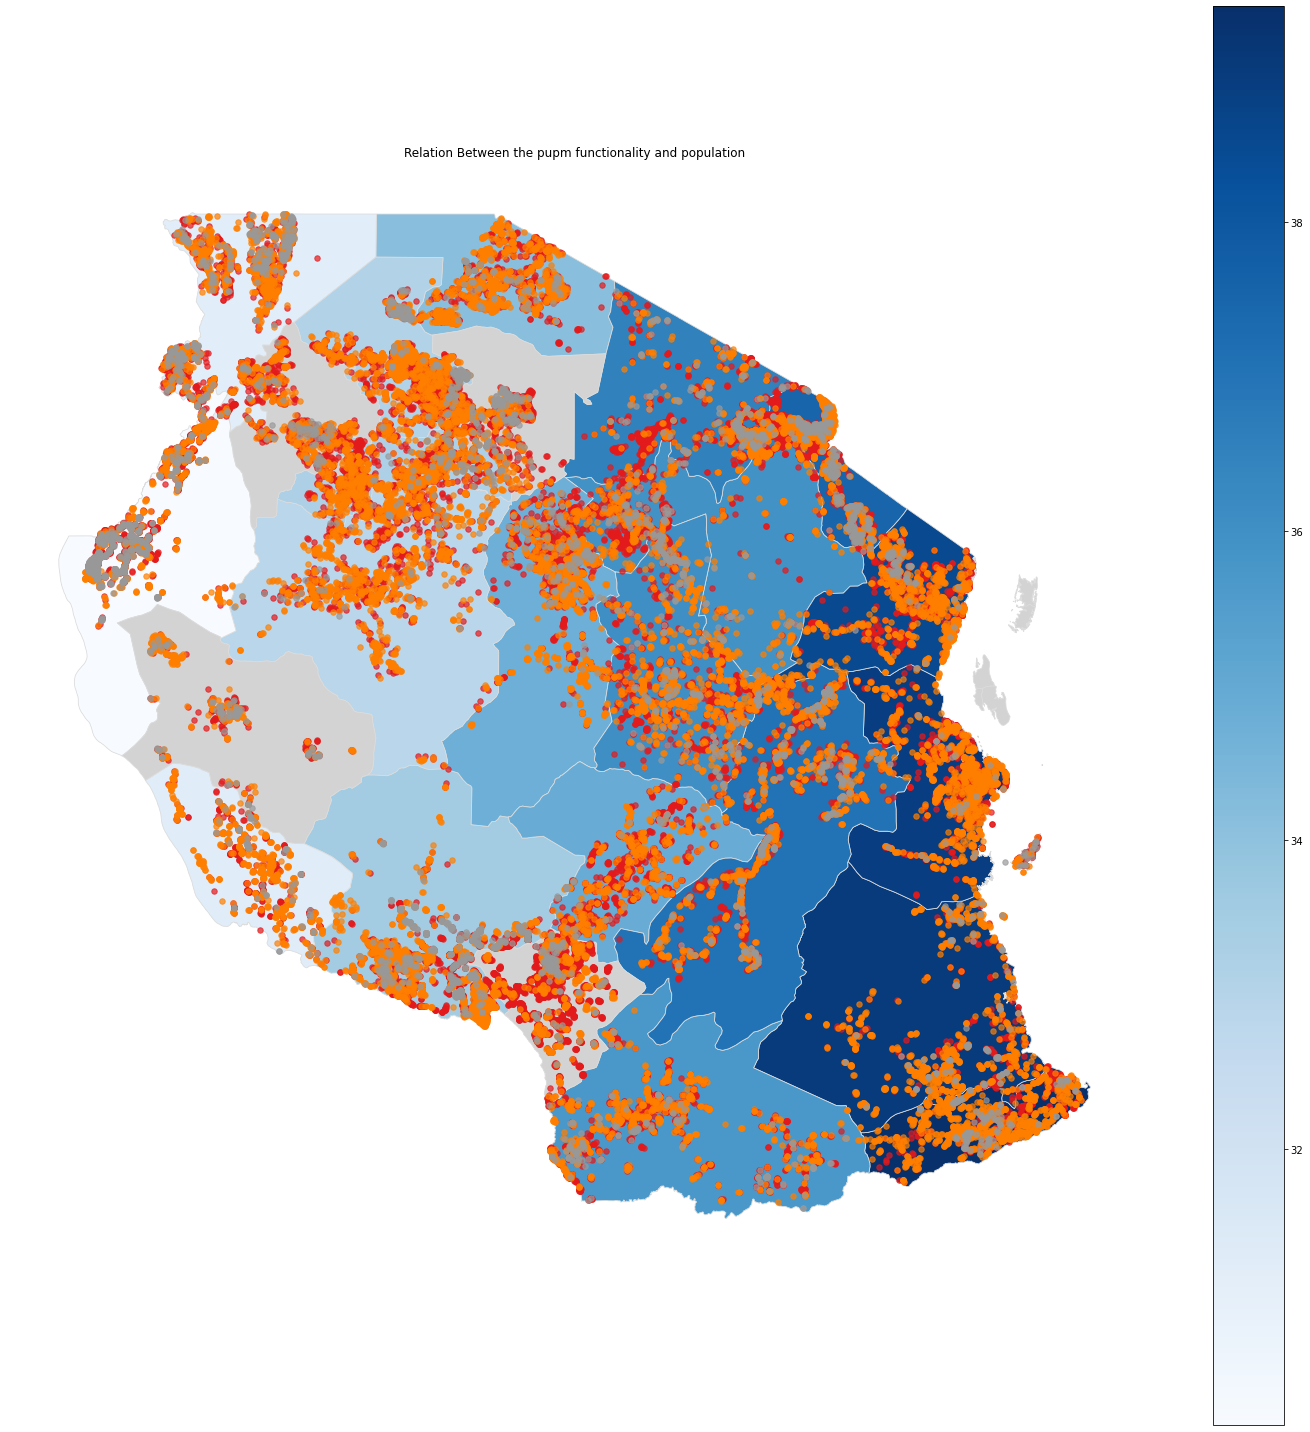

In [57]:
# Step 1: Clean and aggregate quantity by region
df_cleaned['region_clean'] = df_cleaned['region'].str.strip().str.lower()
region_quantity = df_cleaned.groupby('region_clean')['longitude'].mean().reset_index()
region_quantity.rename(columns={'longitude': 'avg_long'}, inplace=True)

# Step 2: Clean region names in geo_data and merge with quantity
geo_data['region_clean'] = geo_data['shapeName'].str.strip().str.lower()
geo_data = geo_data.merge(region_quantity, on='region_clean', how='left')

# Step 3: Plot Tanzania map colored by avg_quantity
ax = geo_data.plot(
    figsize=(20, 20),
    column='avg_long',
    cmap='Blues',
    edgecolor='gainsboro',
    linewidth=0.8,
    legend=True,
    zorder=3,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
unique_status = gdf_points['status_group'].dropna().unique()
cmap = plt.cm.get_cmap('Set1', len(unique_status))

for i, status in enumerate(unique_status):
    subset = gdf_points[gdf_points['status_group'] == status]
    subset.plot(
        ax=ax,
        marker='o',
        color=cmap(i),
        markersize=30,
        label=status,
        alpha=0.7,
        zorder=4
    )

plt.title("Relation Between the pupm functionality and population")
plt.axis("off")
plt.tight_layout()
plt.show()


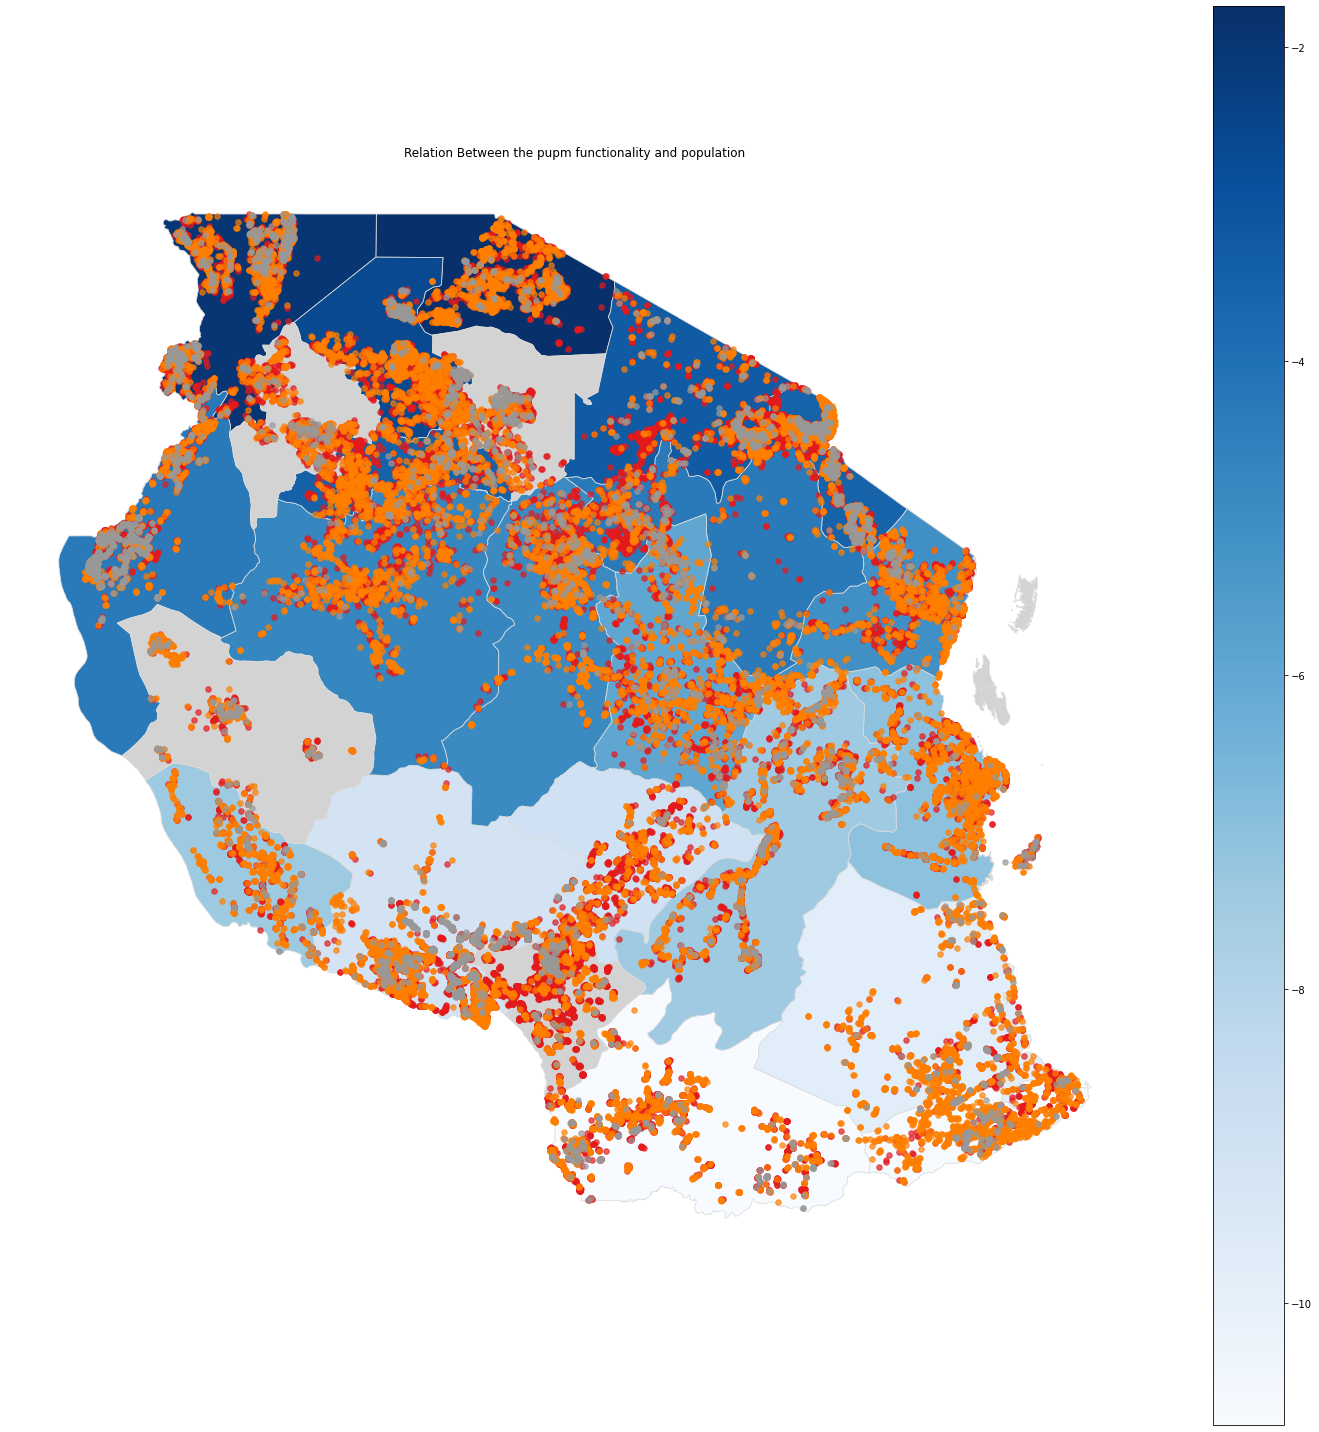

In [58]:
# Step 1: Clean and aggregate quantity by region
df_cleaned['region_clean'] = df_cleaned['region'].str.strip().str.lower()
region_quantity = df_cleaned.groupby('region_clean')['latitude'].mean().reset_index()
region_quantity.rename(columns={'latitude': 'avg_lat'}, inplace=True)

# Step 2: Clean region names in geo_data and merge with quantity
geo_data['region_clean'] = geo_data['shapeName'].str.strip().str.lower()
geo_data = geo_data.merge(region_quantity, on='region_clean', how='left')

# Step 3: Plot Tanzania map colored by avg_quantity
ax = geo_data.plot(
    figsize=(20, 20),
    column='avg_lat',
    cmap='Blues',
    edgecolor='gainsboro',
    linewidth=0.8,
    legend=True,
    zorder=3,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
unique_status = gdf_points['status_group'].dropna().unique()
cmap = plt.cm.get_cmap('Set1', len(unique_status))

for i, status in enumerate(unique_status):
    subset = gdf_points[gdf_points['status_group'] == status]
    subset.plot(
        ax=ax,
        marker='o',
        color=cmap(i),
        markersize=30,
        label=status,
        alpha=0.7,
        zorder=4
    )

plt.title("Relation Between the pupm functionality and population")
plt.axis("off")
plt.tight_layout()
plt.show()


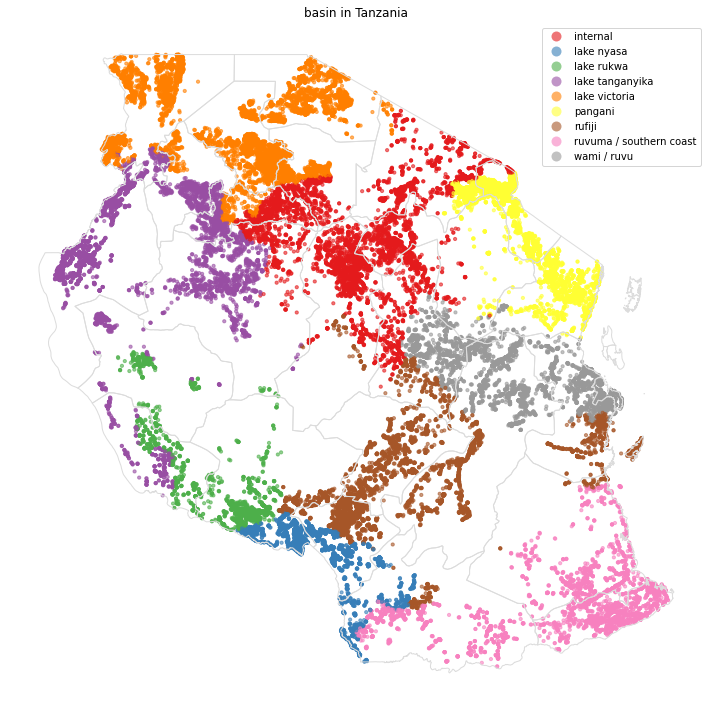

In [61]:
ax = geo_data.plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)

gdf_points.plot(ax=ax,
    column="basin",
    cmap="Set1",
    markersize=10,
    legend=True,
    alpha=0.6)

plt.title("basin in Tanzania")
plt.axis("off")
plt.tight_layout()
plt.show()